In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [9]:
df = pd.read_csv('../cleaned_data/TLKM.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-1.901334,-1.927720,-1.944208,-1.101544,0.683641,0.956443,1.268434,1.023638,1.496048,1.474483,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,-1.884821
2012-10-18,-1.895749,-1.920264,-1.939855,-1.125565,0.002534,0.390498,0.764540,0.097491,0.901053,0.930980,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,-1.910838
2012-10-19,-1.895749,-1.916537,-1.936745,-1.125565,0.002534,0.390498,0.764540,0.479965,1.377288,1.339236,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,-1.910838
2012-10-22,-1.895749,-1.911877,-1.933636,-1.125565,-0.640938,-0.151083,0.278258,-0.448894,0.849284,0.941209,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,-1.936855
2012-10-23,-1.903195,-1.910945,-1.931770,-1.049270,0.052614,0.327538,0.664071,-0.448894,0.621549,1.174465,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,-1.910838


### Plot the Close price - our target

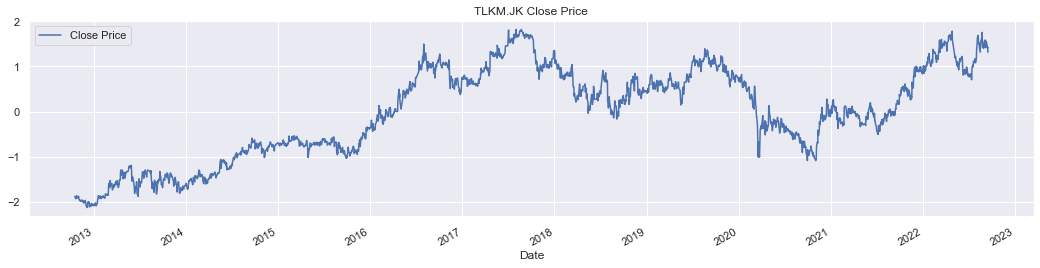

In [10]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('TLKM.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [11]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [13]:
import statsmodels.api as sm

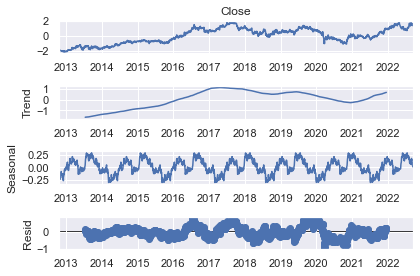

In [14]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [15]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [16]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [17]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


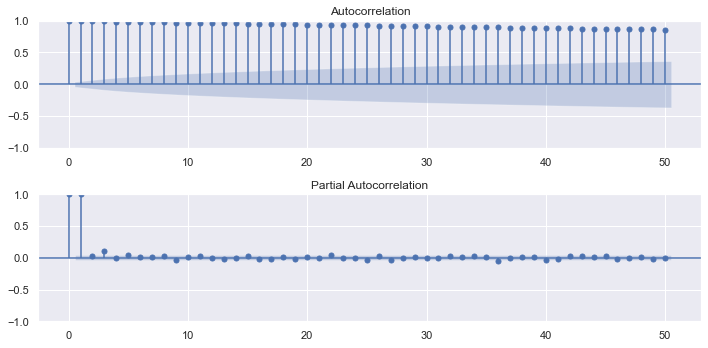

In [18]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [19]:
from pmdarima.arima import auto_arima

In [20]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-1885.500, Time=0.28 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-3897.864, Time=1.20 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-3174.593, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-1886.659, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-3463.201, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-4097.635, Time=2.26 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-1947.687, Time=0.98 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-4106.203, Time=3.07 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-3917.944, Time=1.80 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=7.04 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-4106.7

In [21]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, 0, 5)   Log Likelihood                2062.055
Date:                           Wed, 23 Nov 2022   AIC                          -4110.110
Time:                                   00:22:08   BIC                          -4071.038
Sample:                                        0   HQIC                         -4095.749
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9186      0.017     55.152      0.000       0.886       0.951
ar.L2         -0.1109      0.025     -4.524      0.000      -0.159      -0.063
ar.L3          0.0750      0.026      2.888      0.004       0.024       0.126
ar.L4         -0.0438      0.019     -2.322      0.020      -0.081      -0.007
ar.S.L5       -0.6016      0.021    -28.189      0.000      -0.643      -0.560
ar.S.L10      -0.3089      0.020    -15.761      0.000      -0.347      -0.270
sigma2         0.0071      0.000     45.205      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               463.32
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

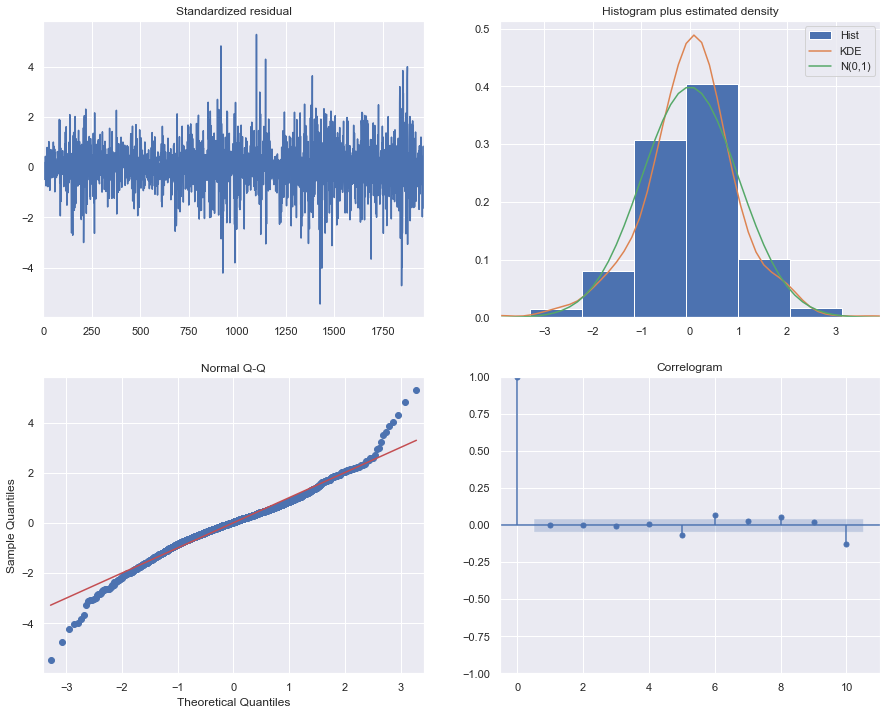

In [22]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(4,0,0), seasonal_order=(2,1,0,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4297.333
Date:                           Wed, 23 Nov 2022   AIC                          -8546.666
Time:                                   00:22:36   BIC                          -8412.705
Sample:                                        0   HQIC                         -8497.431
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1133      0.022      5.173      0.000       0.070       0.156
14 DAYS MA        -0.0586      0.043     -1.352      0.177      -0.144       0.026
21 DAYS MA         0.3896      0.050      7.797      0.000       0.292       0.488
7 DAYS STD DEV    -0.0013      0.001     -1.250      0.211      -0.003       0.001
RSI 7              0.0606      0.007      8.437      0.000       0.047       0.075
RSI 14            -0.4152      0.027    -15.199      0.000      -0.469      -0.362
RSI 21             0.5703      0.022     25.466      0.000       0.526       0.614
MFI 7              0.0029      0.001      1.979      0.048    2.83e-05       0.006
MFI 14            -0.0003      0.002     -0.156      0.876      -0.004       0.004
MFI 21            -0.0003      0.002     -0.128      0.898      -0.005       0.004
dayofweek       7.343e-05      0.001      0.104      0.917      -0.001       0.001
quarter            0.0123      0.007      1.716      0.086      -0.002       0.026
month             -0.2262      0.323     -0.701      0.484      -0.859       0.407
year               0.3993      0.284      1.407      0.159      -0.157       0.955
dayofyear          0.2606      0.326      0.798      0.425      -0.379       0.900
dayofmonth        -0.0189      0.027     -0.708      0.479      -0.071       0.033
weekofyear        -0.0013      0.007     -0.190      0.849      -0.015       0.012
ar.L1              0.8446      0.013     63.347      0.000       0.818       0.871
ar.L2             -0.1595      0.018     -8.778      0.000      -0.195      -0.124
ar.L3              0.2435      0.018     13.462      0.000       0.208       0.279
ar.L4             -0.1009      0.015     -6.631      0.000      -0.131      -0.071
ar.S.L5           -0.6072      0.018    -34.144      0.000      -0.642      -0.572
ar.S.L10          -0.2043      0.017    -11.904      0.000      -0.238      -0.171
sigma2             0.0007   1.23e-05     59.331      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  29.26   Jarque-Bera (JB):              5366.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [27]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [29]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [30]:
predictions

,Pred,Actual
Date,,
2020-09-10,-0.883015,-0.909183
2020-09-11,-0.737351,-0.766089
2020-09-14,-0.642419,-0.662021
2020-09-15,-0.702412,-0.740072
2020-09-16,-0.745295,-0.792106
...,...,...
2022-09-12,0.908489,1.484382
2022-09-13,0.887124,1.458365
2022-09-14,0.841034,1.406331


<AxesSubplot:xlabel='Date'>

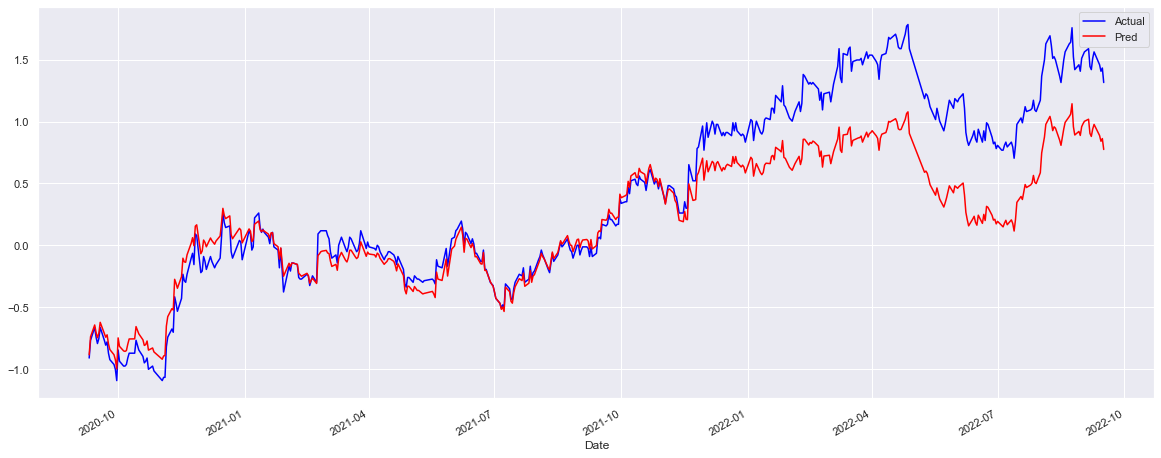

In [31]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [32]:
from joblib import load

In [33]:
close_scaler = load('../feature_engineering/tlkm_close_scaler.bin')

In [34]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [35]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,2720.115815,2700.0
2020-09-11,2832.092285,2810.0


**Plot Error Distribution**

In [36]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

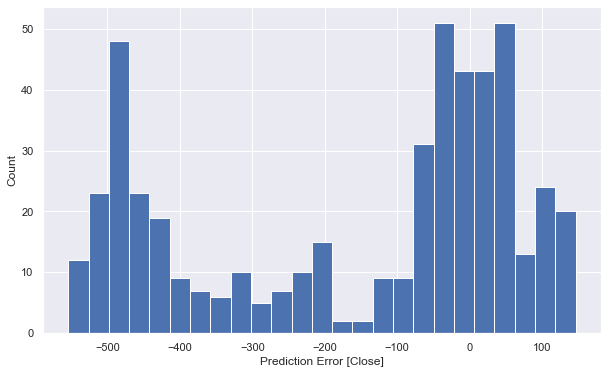

In [46]:
plt.figure(figsize=(10,6))
plotErrorHist(inversed)

**RMSE**

In [38]:
from statsmodels.tools.eval_measures import rmse

In [39]:
rmse(inversed['Pred'], inversed['Actual'])

272.10234760073575

**MAPE**

In [40]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [41]:
mape(inversed['Actual'], inversed['Pred'])

4.76679841530926

**R-squared**

In [42]:
from sklearn.metrics import r2_score

In [43]:
r2_score(inversed['Actual'], inversed['Pred'])

0.7700844145320531

### Save the model

In [44]:
from joblib import dump, load
dump(results, './models/tlkm.joblib') 

['./models/tlkm.joblib']

In [45]:
loaded = load('./models/tlkm.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4297.333
Date:                           Wed, 23 Nov 2022   AIC                          -8546.666
Time:                                   00:23:33   BIC                          -8412.705
Sample:                                        0   HQIC                         -8497.431
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1133      0.022      5.173      0.000       0.070       0.156
14 DAYS MA        -0.0586      0.043     -1.352      0.177      -0.144       0.026
21 DAYS MA         0.3896      0.050      7.797      0.000       0.292       0.488
7 DAYS STD DEV    -0.0013      0.001     -1.250      0.211      -0.003       0.001
RSI 7              0.0606      0.007      8.437      0.000       0.047       0.075
RSI 14            -0.4152      0.027    -15.199      0.000      -0.469      -0.362
RSI 21             0.5703      0.022     25.466      0.000       0.526       0.614
MFI 7              0.0029      0.001      1.979      0.048    2.83e-05       0.006
MFI 14            -0.0003      0.002     -0.156      0.876      -0.004       0.004
MFI 21            -0.0003      0.002     -0.128      0.898      -0.005       0.004
dayofweek       7.343e-05      0.001      0.104      0.917      -0.001       0.001
quarter            0.0123      0.007      1.716      0.086      -0.002       0.026
month             -0.2262      0.323     -0.701      0.484      -0.859       0.407
year               0.3993      0.284      1.407      0.159      -0.157       0.955
dayofyear          0.2606      0.326      0.798      0.425      -0.379       0.900
dayofmonth        -0.0189      0.027     -0.708      0.479      -0.071       0.033
weekofyear        -0.0013      0.007     -0.190      0.849      -0.015       0.012
ar.L1              0.8446      0.013     63.347      0.000       0.818       0.871
ar.L2             -0.1595      0.018     -8.778      0.000      -0.195      -0.124
ar.L3              0.2435      0.018     13.462      0.000       0.208       0.279
ar.L4             -0.1009      0.015     -6.631      0.000      -0.131      -0.071
ar.S.L5           -0.6072      0.018    -34.144      0.000      -0.642      -0.572
ar.S.L10          -0.2043      0.017    -11.904      0.000      -0.238      -0.171
sigma2             0.0007   1.23e-05     59.331      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  29.26   Jarque-Bera (JB):              5366.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""